# MP4: Hidden Markov Model

In this MP, you will train a hidden Markov model in order to segment the sample utterance at https://catalog.ldc.upenn.edu/LDC93S1.  The file you're looking at right now (mp4overview.ipynb) is recommended as a debugging tool, to be used together with the distributed solutions, solutions.hdf5.  The file you actually need to complete is mp4.py.  The unit tests are provided in run_tests.py and tests/test_visible.py.  All of these are available as part of the code package, https://courses.engr.illinois.edu/ece417/fa2020/ece417_20fall_mp4.zip.

In [1]:
import numpy  as np
import wave
import matplotlib.figure
import matplotlib.pyplot as plt
%matplotlib inline

You need to do `pip install librosa` before you run the next block.

In [2]:
import librosa

If you have any top-level syntax errors in your mp3.py file, they will appear in the response to the following line.

In [3]:
import mp4
import importlib
importlib.reload(mp4)

<module 'mp4' from 'C:\\Users\\66403\\UIUC_Courses\\ECE417\\ece417_20fall_mp4\\mp4.py'>

## How to debug

In order to reduce the length of this overview, every block below has two options: you can either show your own results, or you can show the distributed solutions.  In order to decide which one you want to see, you should just comment out the other one.

In [4]:
import h5py
solutions = h5py.File('solutions.hdf5','r')

## Browsing the Data

In this MP we will only use one audio file, which is a publicly distributed sample from the TIMIT corpus (https://catalog.ldc.upenn.edu/LDC93S1).  Let's load it, and look at the spectrogram.

Text(0.5, 1.0, 'She had your dark suit in greasy wash water all year')

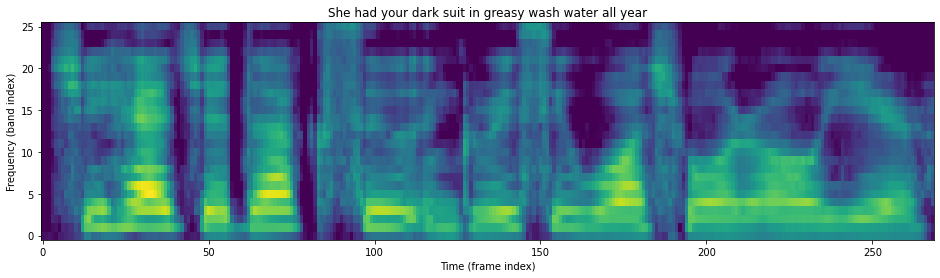

In [5]:
with wave.open('data/LDC93S1.wav','rb') as w:
    fs = w.getframerate()
    nsamples = w.getnframes()
    wav = np.frombuffer(w.readframes(nsamples),dtype=np.int16).astype('float32')
N = 512
skip = int(0.01*fs)
L = int(0.03*fs)
magmel = librosa.feature.melspectrogram(y=wav,sr=fs,n_fft=N,hop_length=skip,
                                   power=1,win_length=L,n_mels=26) 
X = np.log(np.maximum(1e-3,magmel/np.amax(magmel)))
fig=plt.figure(figsize=(16,4))
ax=fig.subplots()
ax.imshow(X,aspect='auto',origin='lower')
ax.set_ylabel('Frequency (band index)')
ax.set_xlabel('Time (frame index)')
ax.set_title('She had your dark suit in greasy wash water all year')


Now let's load the transcription.  Notice that TIMIT is basically ARPABET, with a few extra symbols:
* h# is used for silence at beginning and end of the file
* epi is epinthetic silence (caused by overlap of a fricative and nasal)
* ix, axr, and dx are unstressed versions of ih, er, and d
* ux is a fronted uw (like the IPA phone /y/, which is v in Pinyin)
* hv is a voiced hh, like in the word "aha!"
* q is a glottal stop, like in the word "uh-oh!"
* dcl, kcl, and gcl are the closure (silent) portions of d, k, and g

In [6]:
transcript=[]
with open('data/LDC93S1.phn') as f:
    for line in f:
        fields = line.strip().split()
        if len(fields)>1:
            transcript.append(fields[2])
print('Transcript is "%s"'%(' '.join(transcript)))

Transcript is "h# sh ix hv eh dcl jh ih dcl d ah kcl k s ux q en gcl g r ix s ix w ao sh epi w ao dx axr ao l y ih axr h#"


It will be useful to create a mapping from phone symbols to integer state indices.  It will be easiest if this mapping starts with phn2idx['h#']=0, and then increments from there -- that way, we can force the HMM to always start and end in state 0.

In [7]:
phn2idx = {}
for p in transcript:
    if p not in phn2idx:
        phn2idx[p]=len(phn2idx)
idx2phn = { i:p for (p,i) in phn2idx.items() }
idx2phn

{0: 'h#',
 1: 'sh',
 2: 'ix',
 3: 'hv',
 4: 'eh',
 5: 'dcl',
 6: 'jh',
 7: 'ih',
 8: 'd',
 9: 'ah',
 10: 'kcl',
 11: 'k',
 12: 's',
 13: 'ux',
 14: 'q',
 15: 'en',
 16: 'gcl',
 17: 'g',
 18: 'r',
 19: 'w',
 20: 'ao',
 21: 'epi',
 22: 'dx',
 23: 'axr',
 24: 'l',
 25: 'y'}

## Initialize the HMM

Before we train the HMM, we need to initialize it.  Random initialization is possible, but since Baum-Welch is a local optimization algorithm (like gradient descent), we can improve the result of training by initializing the model in a smart way.  In this MP, you are asked to initialize it by first uniformly dividing the waveform into segments, all of equal length, and estimating the initial HMM from those equal-length segments.

In [8]:
importlib.reload(mp4)
T = X.shape[1]
Quniform = mp4.todo_Quniform(transcript,phn2idx,T)

Here is a utility function to plot the transcription along the time axis of the melspectrogram.

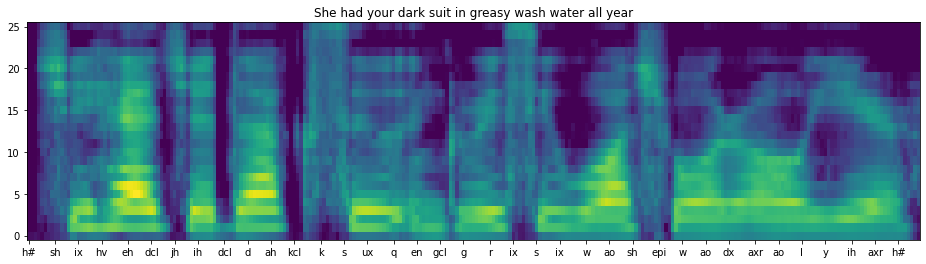

In [9]:
def show_transcript(X,Q,idx2phn):
    fig=plt.figure(figsize=(16,4))
    ax=fig.subplots()
    ax.imshow(X,aspect='auto',origin='lower')
    ax.set_title('She had your dark suit in greasy wash water all year')
    xticklabels = [idx2phn[0]]
    xticks = [0]
    for t in range(1,len(Q)):
        if Q[t] != Q[t-1]:
            xticks.append(t)
            xticklabels.append(idx2phn[Q[t]])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    return(ax)
#ax=show_transcript(X,Quniform,idx2phn)
ax=show_transcript(X,solutions['Quniform'],idx2phn)

The uniform segmentation is obviously not quite right, but maybe it's better than nothing.  Let's use it to initialize the HMM.  To check our work, let's just print out the first three rows of the resulting transition probability matrix.

In [10]:
importlib.reload(mp4)
Lambda=mp4.todo_Lambda(Quniform,X)
#solutions_Lambda = mp4.HiddenMarkovModel(solutions['A'],solutions['mu'],solutions['var'])
Lambda.A[0:3,:]
#solutions_Lambda.A[0:3,:]

array([[0.5       , 0.5       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.33333333, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.25      , 0.25      , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.25      , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.25      ,
      

Let's create another utility function to plot some aspect of the model, maybe the trained means and standard deviations.

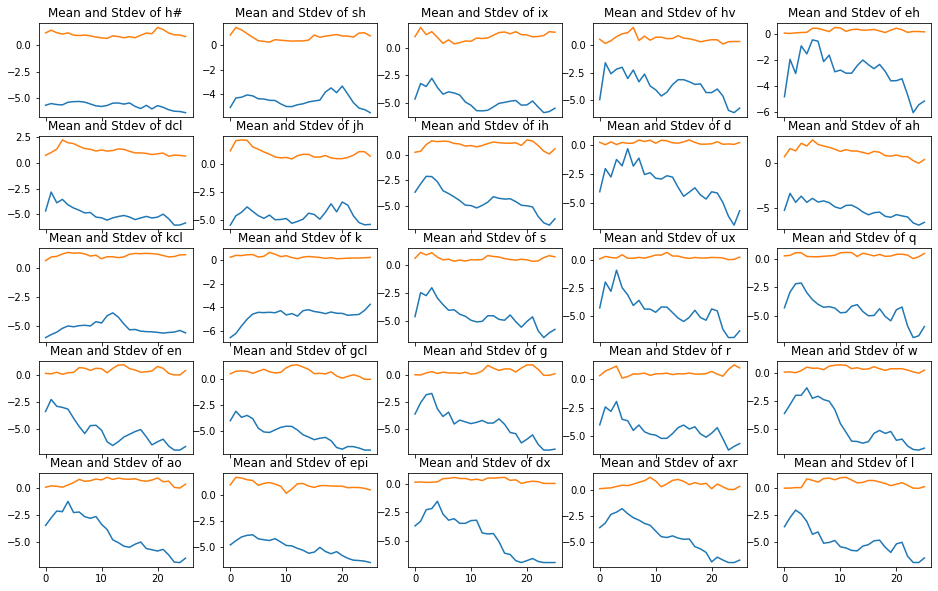

In [11]:
def plot_model(Lambda,idx2phn):
    nstates, nfeats = Lambda.mu.shape
    fig=plt.figure(figsize=(16,10))
    axs=fig.subplots(5,5,sharex=True)
    for row in range(5):
        for col in range(5):
            i=5*row+col
            axs[row,col].plot(np.arange(nfeats),Lambda.mu[i,:])
            axs[row,col].plot(np.arange(nfeats),np.sqrt(Lambda.var[i,:]))
            axs[row,col].set_title('Mean and Stdev of %s'%(idx2phn[i]))
    return(axs)
axs=plot_model(Lambda,idx2phn)
#axs=plot_model(solutions_Lambda,idx2phn)

## Segmentation: the Viterbi algorithm

Even though this initial model is not very good yet, let's use the Viterbi algorithm to re-segment the audio file.  Maybe the result will be exactly like the uniform segmentation, maybe not, let's find out.  First, we'll calculate the observation probabilities in each frame.

In [15]:
importlib.reload(mp4)
logB, Bscaled = mp4.todo_Bscaled(X,Lambda)
Bscaled.shape

(26, 269)

Text(0.5, 1.0, 'Scaled observation probabilities vs. Uniform segmentation')

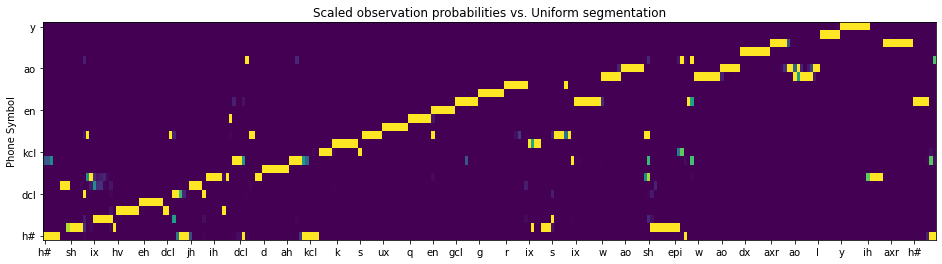

In [16]:
def show_probabilities_as_image(P,Q,idx2phn):
    ax=show_transcript(P,Q,idx2phn)
    ax.set_yticks(np.arange(0,26,5))
    labels=ax.set_yticklabels([idx2phn[x] for x in np.arange(0,26,5)])
    ax.set_ylabel('Phone Symbol')
    return(ax)
ax=show_probabilities_as_image(Bscaled,Quniform,idx2phn)
#ax=show_probabilities_as_image(solutions['Bscaled'],solutions['Quniform'],idx2phn)
ax.set_title('Scaled observation probabilities vs. Uniform segmentation')

Now we'll use the Viterbi algorithm to find the log likelihood of the most likely path to each state at each time.

Text(0.5, 1.0, 'Log path probabilities vs. Uniform segmentation')

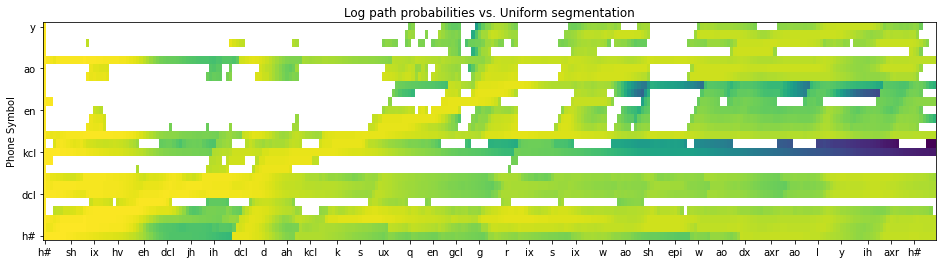

In [23]:
importlib.reload(mp4)
logdelta, psi = mp4.todo_logdelta(Bscaled, Lambda)
ax=show_probabilities_as_image(logdelta, Quniform, idx2phn)
ax.set_title('Log path probabilities vs. Uniform segmentation')

Finally, we backtrace through the psi matrix in order to find the best path, given the current model.

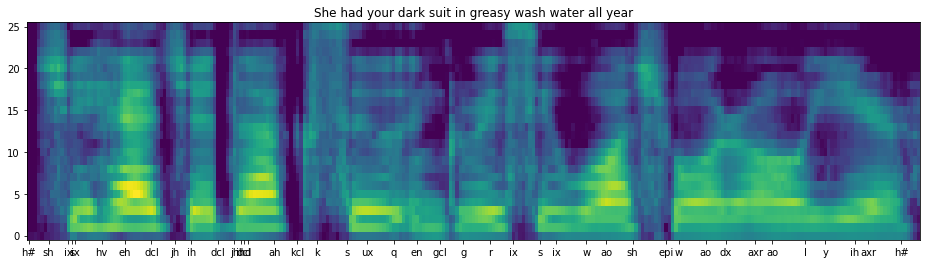

In [28]:
importlib.reload(mp4)
Qstar = mp4.todo_Qstar(psi)
ax=show_transcript(X,Qstar,idx2phn)
#ax = show_transcript(X,solutions['Qstar'],idx2phn)

## Training: the Forward-Backward Algorithm

Now we'll use the forward-backward algorithm to re-estimate the model.

Text(0.5, 1.0, 'Forward probs vs. Viterbi segmentation')

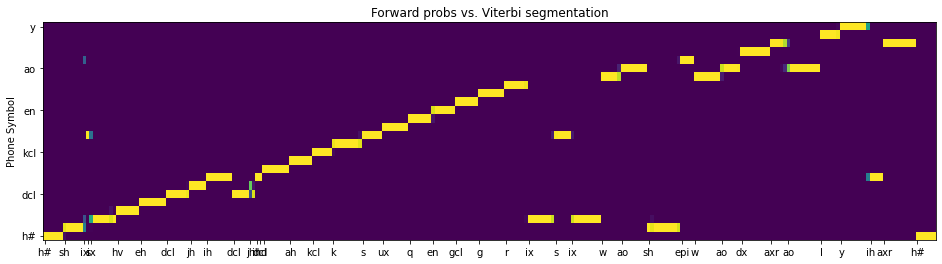

In [30]:
importlib.reload(mp4)
alphahat,G=mp4.todo_alphahat(Bscaled,Lambda)
ax=show_probabilities_as_image(alphahat,Qstar,idx2phn)
#ax=show_probabilities_as_image(solutions['alphahat'],solutions['Qstar'],idx2phn)
ax.set_title('Forward probs vs. Viterbi segmentation')

Text(0.5, 1.0, 'Log scaling factor as a function of frame index')

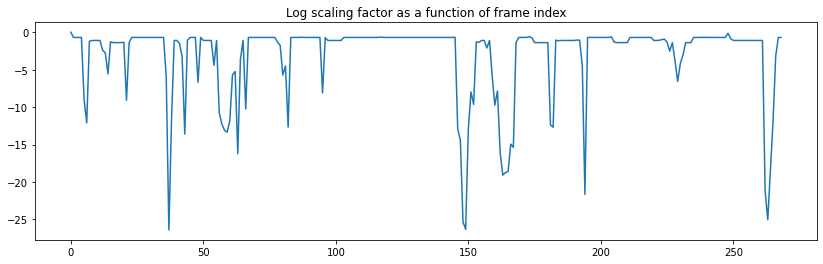

In [31]:
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
ax.plot(np.log(G))
#ax.plot(np.log(solutions['G']))
ax.set_title('Log scaling factor as a function of frame index')

Text(0.5, 1.0, 'Log backward probs vs. Viterbi segmentation')

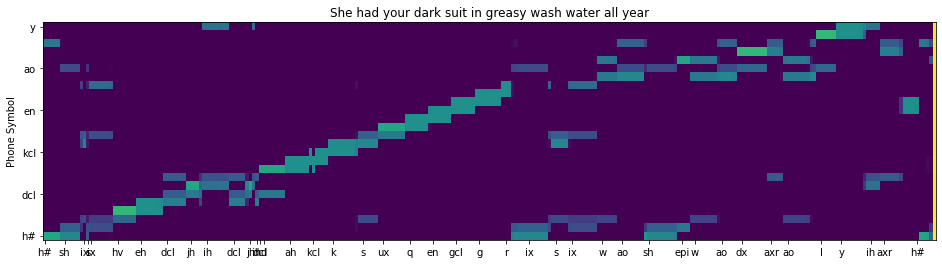

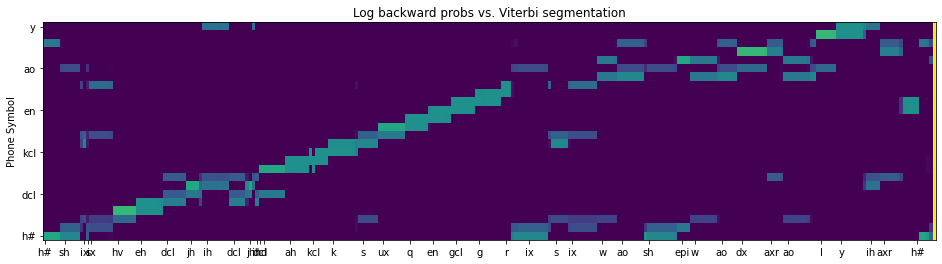

In [33]:
importlib.reload(mp4)
betahat=mp4.todo_betahat(Bscaled,Lambda)
ax=show_probabilities_as_image(betahat,Qstar,idx2phn)
ax=show_probabilities_as_image(solutions['betahat'],solutions['Qstar'],idx2phn)
ax.set_title('Log backward probs vs. Viterbi segmentation')

Text(0.5, 1.0, 'Xi, summed over time')

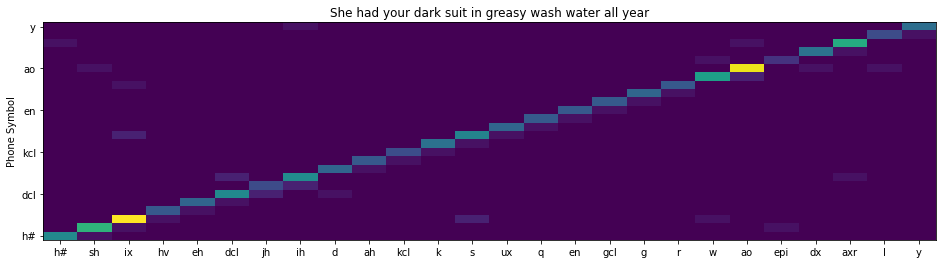

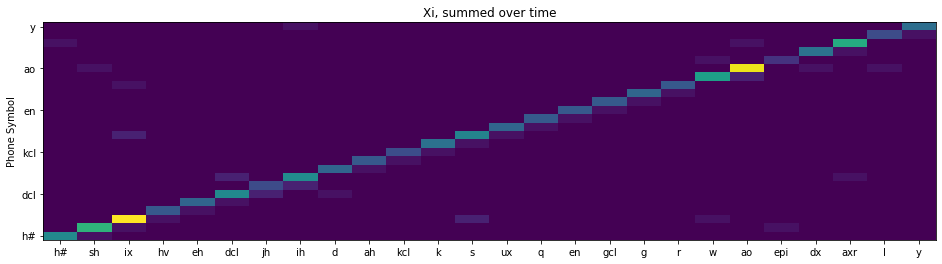

In [34]:
importlib.reload(mp4)
xi = mp4.todo_xi(alphahat, betahat, Bscaled, Lambda)
ax=show_probabilities_as_image(np.sum(xi,axis=0),np.arange(len(idx2phn)),idx2phn)
ax=show_probabilities_as_image(np.sum(solutions['xi'],axis=0),np.arange(len(idx2phn)),idx2phn)
ax.set_title('Xi, summed over time')

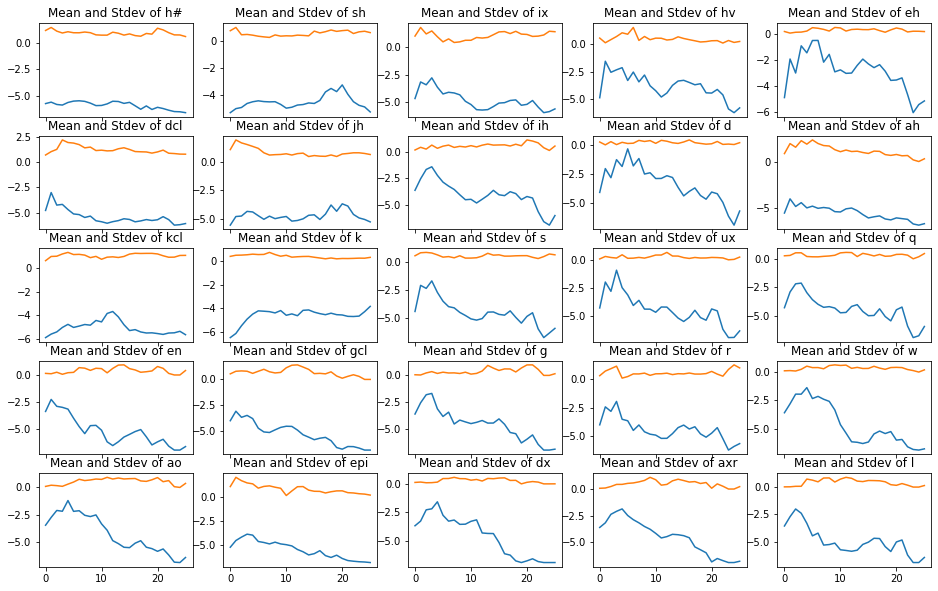

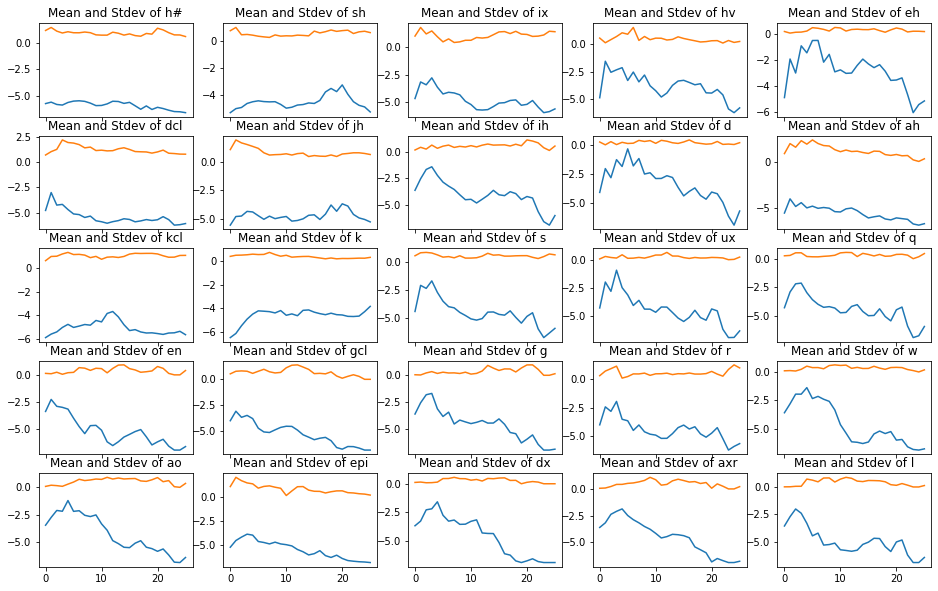

In [35]:
importlib.reload(mp4)
Lambdaprime = mp4.todo_Lambdaprime(xi,X)
solutions_Lambdaprime=mp4.HiddenMarkovModel(solutions['Aprime'],solutions['muprime'],solutions['varprime'])
axs=plot_model(Lambdaprime,idx2phn)
axs=plot_model(solutions_Lambdaprime,idx2phn)

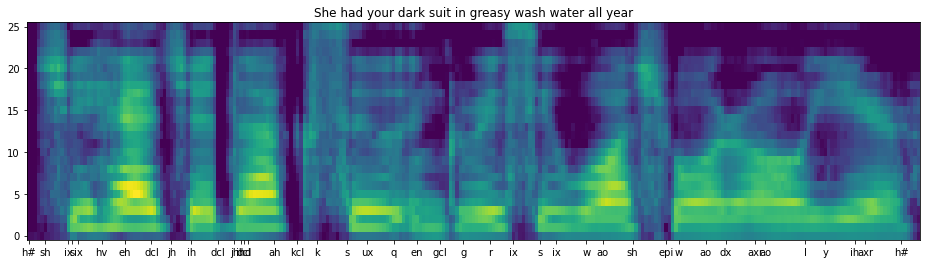

In [36]:
logB, Bscaled = mp4.todo_Bscaled(X,Lambdaprime)
logdelta, psi = mp4.todo_logdelta(Bscaled, Lambdaprime)
Qstar = mp4.todo_Qstar(psi)
ax=show_transcript(X,Qstar,idx2phn)